In [1]:
#Importing Libraries
import pandas as pd
import numpy as np

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from scipy.stats import zscore
from scipy import stats

In [2]:
#reading Dataset
customer = pd.read_excel("Credit Card Customer Data.xlsx")
customer.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


# 1. Univariate Analysis
Perform univariate analysis on the data to better understand the variables at your disposal and to get an idea about the no of clusters. Perform EDA, create visualizations to explore data.

In [3]:
# Sanity check
customer.shape

(660, 7)

In [4]:
customer.describe().transpose()
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [5]:
# Null values
customer.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

## Outliers

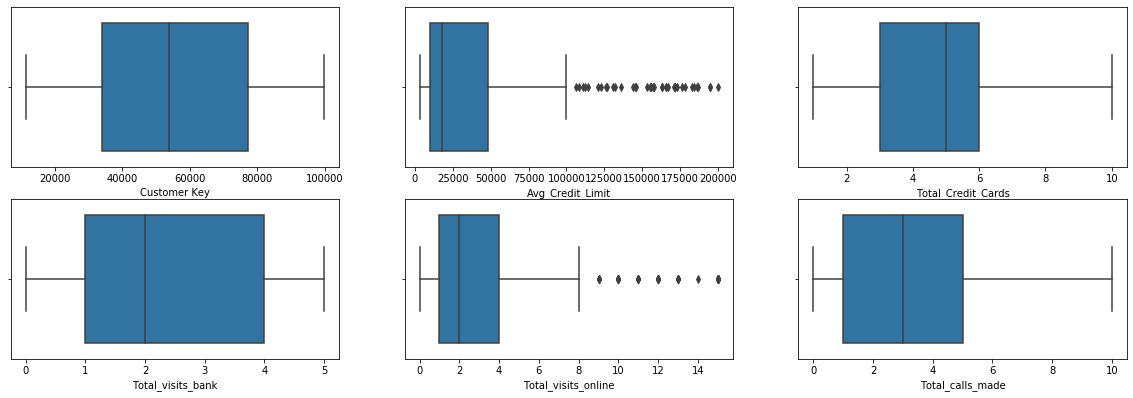

In [6]:
# using subplot(), use a for loop
plt.figure(figsize= (20,10))  # setting the figure size
pos = 1  # we will use this variable to index each of the plots
for i in customer.iloc[:,1:]:
    plt.subplot(3, 3, pos)
    sns.boxplot( customer[i]);
    pos += 1  # to plot over the grid one by one   

In [7]:
Q1 = customer.quantile(0.25)
Q3 = customer.quantile(0.75)
IQR = Q3 - Q1
((customer < (Q1 - 1.5 * IQR)) | (customer > (Q3 + 1.5 * IQR))).sum()

Sl_No                   0
Customer Key            0
Avg_Credit_Limit       39
Total_Credit_Cards      0
Total_visits_bank       0
Total_visits_online    37
Total_calls_made        0
dtype: int64

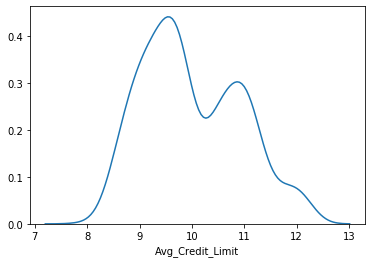

In [8]:
# understanding outliers
sns.distplot(np.log(customer['Avg_Credit_Limit']),hist=False)
plt.show()

In [9]:
customer['Avg_Credit_Limit'] = np.log(customer['Avg_Credit_Limit'])

In [10]:
# Removing outliers 
index  = customer[(customer['Total_visits_online'] > customer['Total_visits_online'].quantile(0.90))|(customer['Total_visits_online'] < customer['Total_visits_online'].quantile(0.10))].index
customer.drop(index, inplace=True)

In [11]:
Q1 = customer.quantile(0.25)
Q3 = customer.quantile(0.75)
IQR = Q3 - Q1
((customer < (Q1 - 1.5 * IQR)) | (customer > (Q3 + 1.5 * IQR))).sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [12]:
customer.shape

(609, 7)

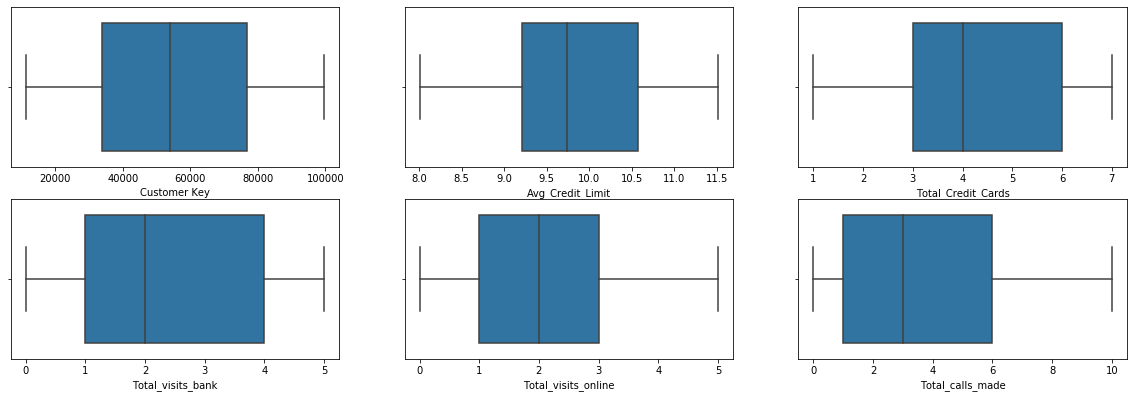

In [13]:
# using subplot(), use a for loop
plt.figure(figsize= (20,10))  # setting the figure size
pos = 1  # we will use this variable to index each of the plots
for i in customer.iloc[:,1:]:
    plt.subplot(3, 3, pos)
    sns.boxplot( customer[i]);
    pos += 1  # to plot over the grid one by one   

In [14]:
##Remove SI_No since it is redundant
customer.drop('Sl_No', axis=1, inplace=True)
##Remove Customer Key since it is redundant
customer.drop('Customer Key', axis=1, inplace=True)

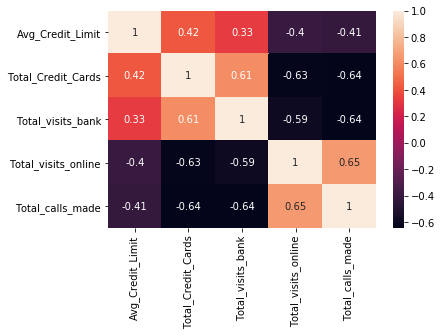

In [15]:
corr = customer.corr()
sns.heatmap(corr, annot = True)

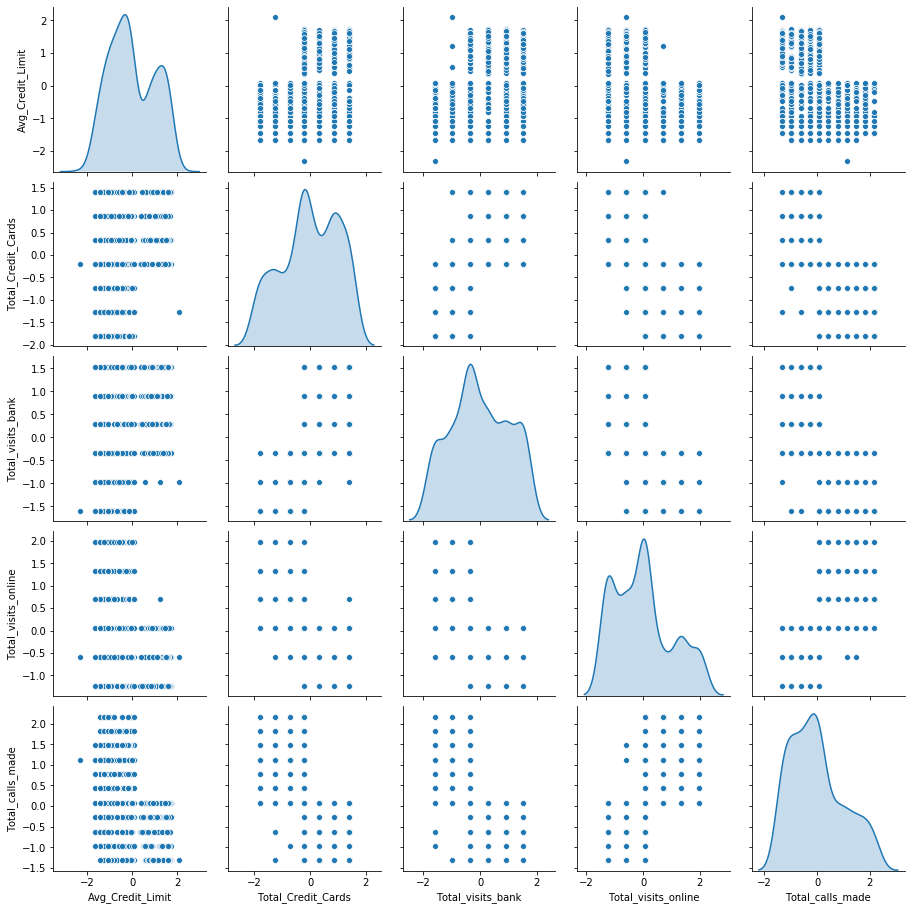

In [16]:
custSuppScaled=customer.apply(zscore)
sns.pairplot(custSuppScaled,diag_kind='kde')

In [17]:
custSuppScaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,2.095739,-1.269834,-0.971454,-0.584386,-1.318344
2,1.225030,1.400501,-0.971454,0.695798,0.076741
3,0.583348,0.332367,-0.971454,-0.584386,0.076741
5,0.074016,-0.735767,-1.596180,-0.584386,1.471827
7,-0.287361,-0.735767,-1.596180,-0.584386,-0.969573


# 2. Insights on Graphs
Properly comment on the codes, provide explanations of the steps taken in the notebook and conclude your insights from the graphs.

* From the above graphs it can be seen that there exists the outliers in Avg_Credit_Limit and Total_visits_online columns. Since K-Means is highly sensitive by the outliers, therefore the outliers are removed.
* Logscale is applied on Avg_Credit_Limit column to nullify the effect of outliers
* The data has been scaled using standard scaler techniques
* From the correlation graphs it can be seen that Total_visits_online and Total_calls_made have good correlation. Also Total_Credit_Cards and Total_visits_bank have good correlation. This gives an intuation about the results that could be expected from clustering. It seems that the customers who visit online for customer service are tend to call customer care. Also people with more number of creditcards tend to visit bank for customer service insted of making calls to customer service or taking help online.

## PCA
As part of EDA, PCA is performed to intuvatively understand the clusters of data in a given dataset. The dimensionality is reduced to visualize the clusters

In [18]:
## Creating a covariance matrix
cov_matrix = np.cov(custSuppScaled.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.00164474  0.42265213  0.32993367 -0.40046027 -0.41439654]
 [ 0.42265213  1.00164474  0.61425275 -0.62971863 -0.64592869]
 [ 0.32993367  0.61425275  1.00164474 -0.59428876 -0.64134237]
 [-0.40046027 -0.62971863 -0.59428876  1.00164474  0.65517466]
 [-0.41439654 -0.64592869 -0.64134237  0.65517466  1.00164474]]


In [19]:
# deriving eigen values and eigen vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[ 0.3395858   0.92419272  0.06026327  0.14081155 -0.08420059]
 [ 0.47388824 -0.08583376  0.03260168 -0.07149983  0.87286162]
 [ 0.45583741 -0.32066589  0.34652715  0.71758889 -0.23317537]
 [-0.46954245  0.12878103 -0.43595102  0.67659023  0.33929001]
 [-0.48151175  0.13816372  0.82775063  0.04849458  0.24806126]]

 Eigen Values 
%s [3.17563396 0.73016181 0.33248444 0.40150712 0.36843635]


In [20]:
# Finding the cumulative covariance
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

Cumulative Variance Explained [ 63.40838915  77.98764636  86.0046029   93.36123019 100.        ]


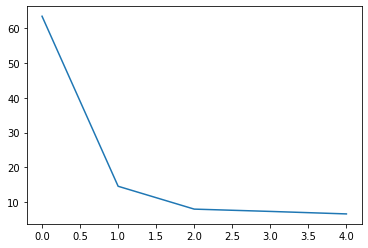

In [21]:
plt.plot(var_exp)

From the above plot we can see that the first 3 principal components have major contribution to the model.

In [22]:
# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
data_reduced = pca.fit_transform(custSuppScaled)
data_reduced.transpose()

array([[-0.57629099, -0.27320012, -0.15021862, ..., -0.93871509,
        -1.72483699, -1.86099066],
       [-2.0999685 , -1.42367443, -0.7574546 , ..., -0.56675379,
        -0.57728344, -0.51283719],
       [ 0.77053028,  0.15025017,  1.03039549, ..., -0.31162254,
         0.67971671, -0.2968167 ]])

In [23]:
data_reduced.shape

(609, 3)

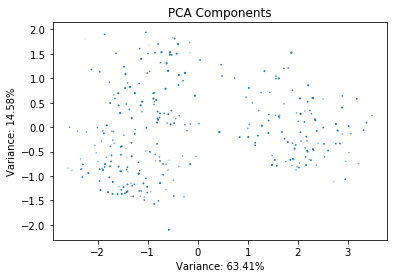

In [24]:
cmp1, cmp2, cmp3 = pca.explained_variance_ratio_
axis = plt.figure().gca(title='PCA Components',
                      xlabel = 'Variance: {:.2%}'.format(cmp1),
                      ylabel = 'Variance: {:.2%}'.format(cmp2))
axis.scatter(*data_reduced.T)

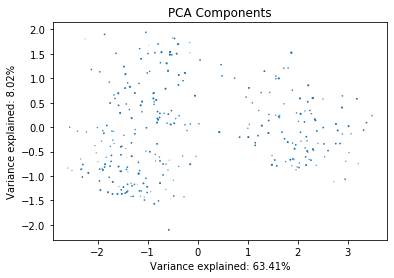

In [25]:
axis = plt.figure().gca(title='PCA Components',
                      xlabel = 'Variance explained: {:.2%}'.format(cmp1),
                      ylabel = 'Variance explained: {:.2%}'.format(cmp3))
axis.scatter(*data_reduced.T)

It can be seen from above that there seems to be 3 clusters in a given dataset with extracted 3 principal components explaining the model variance to 86%. However multi dimensional plots would be much more descriptive in this case.

# 3. K-means Clustering
Execute K-means clustering use elbow plot and analyse clusters using boxplot

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

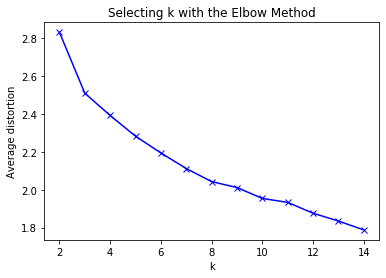

In [26]:
#Finding optimal no. of clusters
from scipy.spatial.distance import cdist
clusters=range(2,15)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(custSuppScaled)
    prediction=model.predict(custSuppScaled)
    meanDistortions.append(sum(np.min(cdist(custSuppScaled, model.cluster_centers_, 'cityblock'), axis=1)) / custSuppScaled.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

The bend is not clear as there are many bends, considering the knee bend I take K = 3

In [27]:
#  K = 3
final_model=KMeans(3)
final_model.fit(custSuppScaled)
prediction=final_model.predict(custSuppScaled)

#Append the prediction 
custSuppScaled_KMeans = custSuppScaled
custSuppScaled_KMeans["GROUP"] = prediction
customer["GROUP"] = prediction
print("Groups Assigned : \n")
customer.head()

Groups Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,11.512925,2,1,1,0,1
2,10.819778,7,1,3,4,1
3,10.308953,5,1,1,4,1
5,9.903488,3,0,1,8,0
7,9.615805,3,0,1,1,2


In [28]:
custSuppClust = customer.groupby(['GROUP'])
custSuppClust.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,
0,9.312109,2.398190,0.936652,3.542986,6.900452
1,10.776538,5.547945,3.401826,0.968037,2.054795
2,9.333151,5.449704,3.573964,1.005917,1.934911


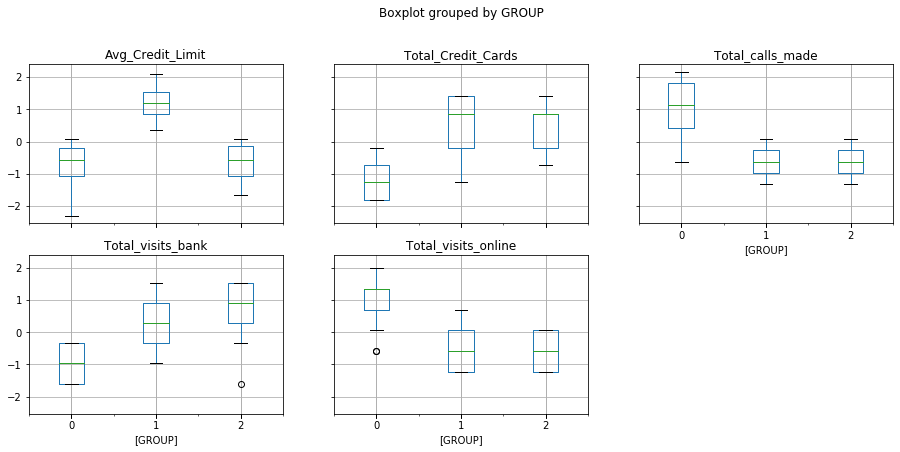

In [29]:
custSuppScaled_KMeans.boxplot(by='GROUP', layout = (3,3),figsize=(15,10));

In [30]:
# computing average silhouette_score
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(custSuppScaled_KMeans)
    sse_.append([k, silhouette_score(custSuppScaled_KMeans, kmeans.labels_)])

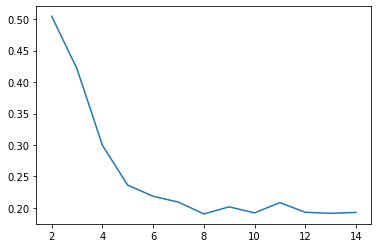

In [31]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

# 4. Hierarchical Clustering
Execute hierarchical clustering (with different linkages) with the help of dendrogram and cophenetic coeff. Analyse clusters formed using boxplot

In [32]:
#### generate the linkage matrix
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
#custSuppScaled = custSuppScaled.iloc[:,:-1]
# Y = linkage(custSuppScaled, 'single', metric='euclidean')
#plt.figure(figsize=(25, 10))
#dendrogram(Y)
#plt.show()

In [33]:
# cophent should be close to 1, for better clustering
#c, coph_dists = cophenet(Y , pdist(custSuppScaled))
#c

In [34]:
#X = linkage(custSuppScaled, 'complete', metric='euclidean')
#plt.figure(figsize=(25, 10))
#dendrogram(X)
#plt.show()

In [35]:
# cophent should be close to 1, for better clustering
#c, coph_dists = cophenet(X , pdist(custSuppScaled))
#c

Experimenting with various linkages and evaluating them based on thier cophnet scores, a linkage with ward method and euclidean method is chosen.

In [36]:
custSuppScaled = custSuppScaled.iloc[:,:-1]
custSuppScaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,2.095739,-1.269834,-0.971454,-0.584386,-1.318344
2,1.225030,1.400501,-0.971454,0.695798,0.076741
3,0.583348,0.332367,-0.971454,-0.584386,0.076741
5,0.074016,-0.735767,-1.596180,-0.584386,1.471827
7,-0.287361,-0.735767,-1.596180,-0.584386,-0.969573


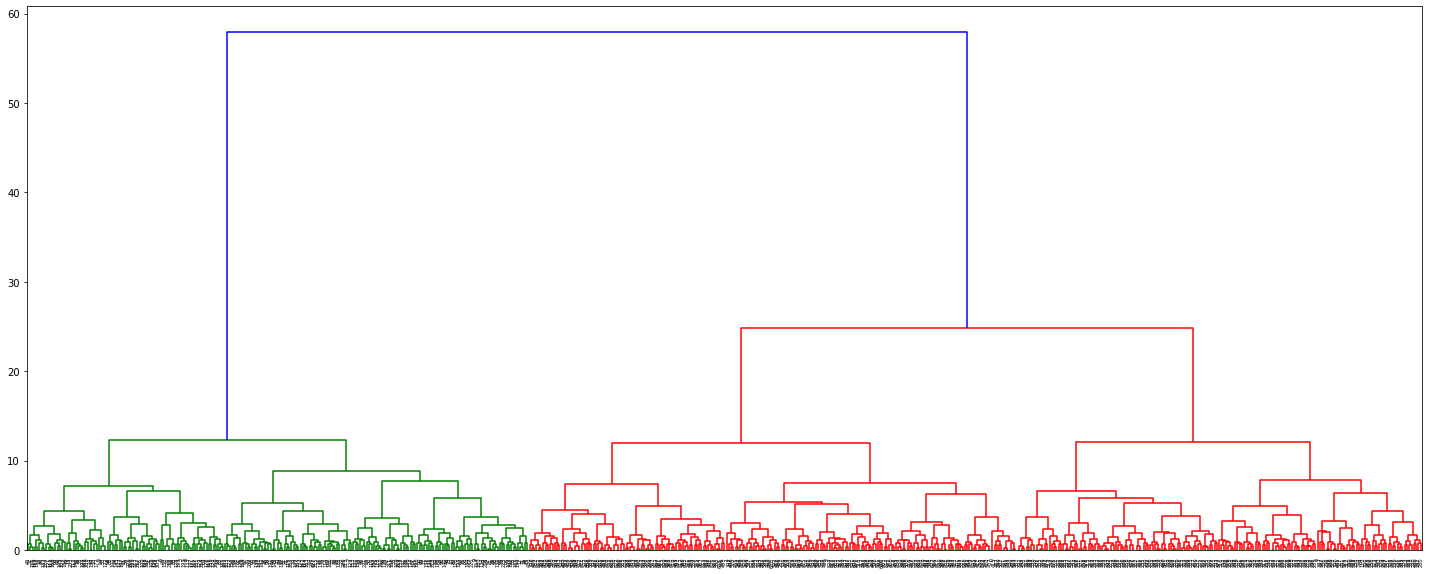

In [37]:
Z = linkage(custSuppScaled, method='ward', metric='euclidean')
plt.figure(figsize=(25, 10))
dendrogram(Z)
plt.show()

In [38]:
# cophent should be close to 1, for better clustering
c, coph_dists = cophenet(Z , pdist(custSuppScaled))
c

0.8219917084324809

From the above dendrograms single and complete linkages seems not to be that great. There fore ward linkage is chosen.

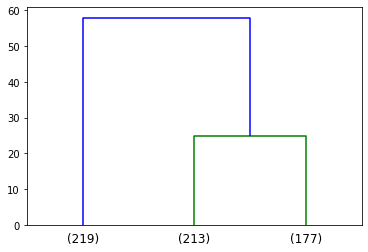

In [39]:
# Using truncate_mode='lastp' attribute in dendrogram function to arrive at dendrogram
dendrogram( Z, 
    truncate_mode='lastp',  # show only the last p merged clusters
    p=3,  # show only the last p merged clusters
)
plt.show()

In [40]:
max_d = 20

In [41]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([2, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [42]:
#Append the prediction 
custSuppScaled_Agglo = custSuppScaled
custSuppScaled_Agglo["GROUP"] = prediction
customer_heirar = customer.iloc[:,:-1]
customer_heirar["GROUP"] = clusters
custSuppScaled_Agglo["GROUP"] = clusters
print("Groups Assigned : \n")
customer_heirar.head()

Groups Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,11.512925,2,1,1,0,2
2,10.819778,7,1,3,4,2
3,10.308953,5,1,1,4,2
5,9.903488,3,0,1,8,1
7,9.615805,3,0,1,1,3


In [43]:
custSuppClust_heirar = customer_heirar.groupby(['GROUP'])
custSuppClust_heirar.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,
1,9.317833,2.383562,0.936073,3.557078,6.922374
2,10.782072,5.586854,3.380282,0.981221,2.075117
3,9.368101,5.389831,3.564972,1.000000,1.943503


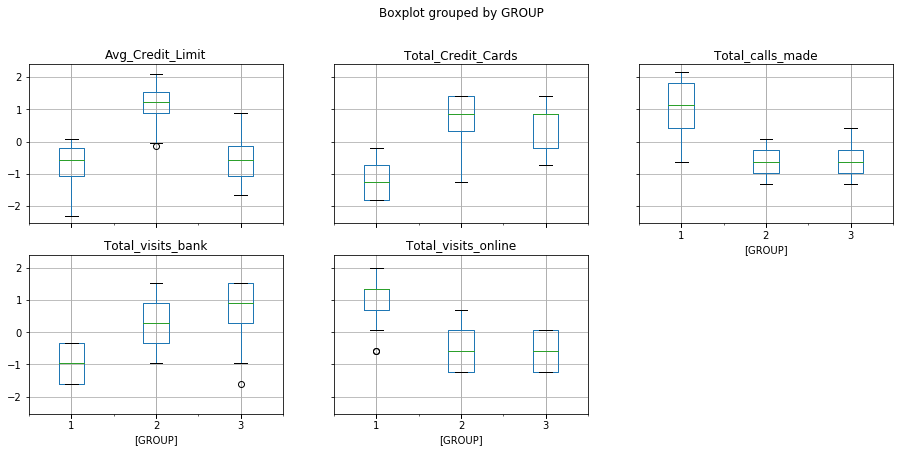

In [44]:
custSuppScaled_Agglo.boxplot(by='GROUP', layout = (3,3),figsize=(15,10));

# 5. Average silhouette score
Calculate average silhouette score for both methods.

## silhouette score for Heirarichical Clustering

In [45]:
# Calculate Avg Silhoutte Score
from sklearn.metrics import silhouette_score
silhouette_score(custSuppScaled,clusters)

0.41232708283325475

In [46]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(custSuppScaled_KMeans)
    sse_.append([k, silhouette_score(custSuppScaled_KMeans, kmeans.labels_)])

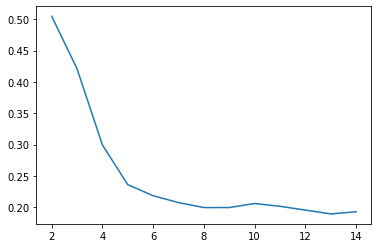

In [47]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

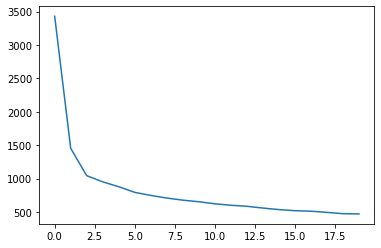

In [48]:
# Let's see of the sum of square errors with the clusters is minimized over the number of iterations
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(custSuppScaled_KMeans)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

From the above graphs and silhouette_score it can be seen that the score lies around 40 - 60.

# 6. Comparision K-means with Hierarchical clusters

## Box Plots comparision

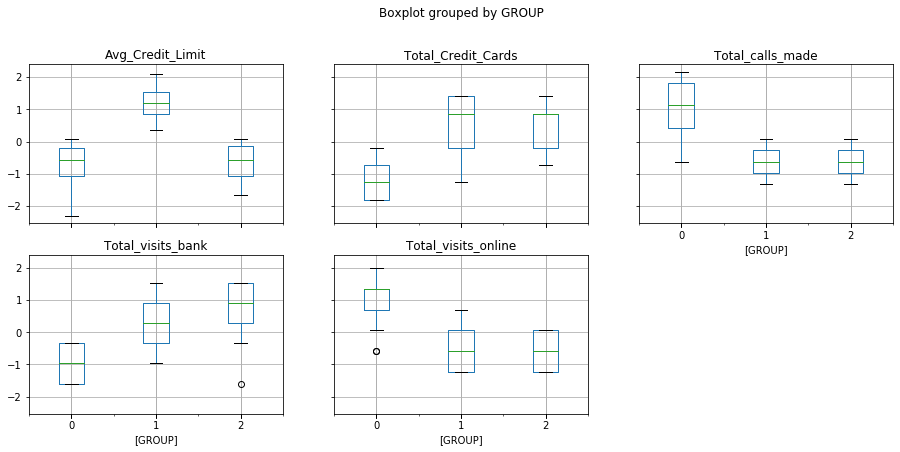

In [49]:
# box plots of K-means 
custSuppScaled_KMeans.boxplot(by='GROUP', layout = (3,3),figsize=(15,10));

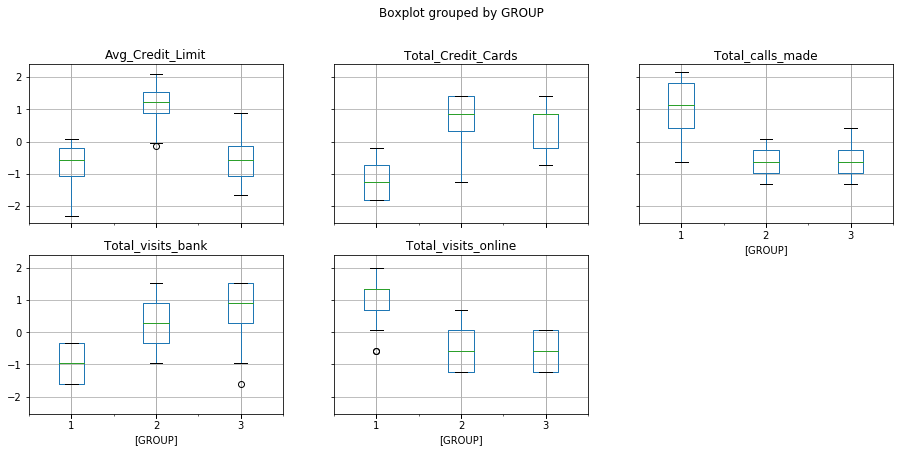

In [50]:
# box plots of Heirarchical clustering 
custSuppScaled_Agglo.boxplot(by='GROUP', layout = (3,3),figsize=(15,10));

## Comparision of clusters means

In [51]:
# mean of clusters of K-Means clustering
custSuppClust = customer.groupby(['GROUP'])
custSuppClust.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,
0,9.312109,2.398190,0.936652,3.542986,6.900452
1,10.776538,5.547945,3.401826,0.968037,2.054795
2,9.333151,5.449704,3.573964,1.005917,1.934911


In [52]:
# mean of clusters of Heirarchical clustering
custSuppClust_heirar = customer_heirar.groupby(['GROUP'])
custSuppClust_heirar.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,
1,9.317833,2.383562,0.936073,3.557078,6.922374
2,10.782072,5.586854,3.380282,0.981221,2.075117
3,9.368101,5.389831,3.564972,1.000000,1.943503


It can be seen that the clusters extracted from the both the methods are almost similar. The variance explained by both the methods is almost the same. These results also reflects our intuation that we gained from PCA computation and scatter plots.

# 7. Analysis of the clusters
Analysis the clusters formed, tell us how is one cluster different from another and answer all the key questions.

How many different segments of customers are there?
* There are three seg,emts of customers are there in the given dataset with unique behaviour. It can be seen from the box plots above. The uniqueness of the clusters can been seen based on if they are able to get their issues resolved online or by phone calls or by paying a visit to the bank. 

How are these segments different from each other?
* These segments are different from eachother based on their activities. It can especially be seen from the above boxplots that these three segments are unique based the number of bank visits they pay inorder to get the customer support. Ideally it is expected to have less number of visits to the bank. The customers should be able to resolve their issues online or by a phone call at the maximum to save their time.

What are your recommendations to the bank on how to better market to and service these customers?
* It can be seen from the box plots above that the customers with more number of creditcards are tend to visit bank to get the customer support. They are the ones with good average credit limit, so they should be given preference and served better.
* By improving the customers service to the people with more creditcards, bank may offer more credit cards to the people who are having less creditcards by given better offers to attract them.
* Based on the above hypothesis the bank shall improve thier customer service and can thereby improve their customer base.